In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alpaca.data import TimeFrame

# Import libraries and dependencies
import api_calls

In [3]:
# Call the alpaca api to get the data

# Set the ticker
ticker = "META"

# Set timeframe to '1D'
timeframe = TimeFrame.Day

# Set start and end datetimes, between now and 100 days ago.
start_date = dt.datetime.now() - dt.timedelta(100)
end_date = dt.datetime.now()

# Get 100 days' worth of historical data for SPY
stock_data = api_calls.call_alpha_vantage_daily(ticker)

stock_data_df = pd.DataFrame(stock_data['Time Series (Daily)']).T

stock_data_df

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2023-03-31,207.24,212.17,206.77,211.94,211.94,25440273,0.0000,1.0
2023-03-30,203.38,208.09,202.82,207.84,207.84,22608303,0.0000,1.0
2023-03-29,203.56,205.72,202.5355,205.35,205.35,18851137,0.0000,1.0
2023-03-28,200.15,201.03,197.9,200.68,200.68,19127295,0.0000,1.0
2023-03-27,204.81,205.86,201.36,202.84,202.84,18527184,0.0000,1.0
...,...,...,...,...,...,...,...,...
2022-11-11,109.23,114.9,108.81,113.02,113.02,59961742,0.0000,1.0
2022-11-10,107.12,112.75,104.61,111.87,111.87,80670961,0.0000,1.0
2022-11-09,101.72,104.9,100.74,101.47,101.47,107677284,0.0000,1.0
2022-11-08,95.92,97.8,94.79,96.47,96.47,52088320,0.0000,1.0


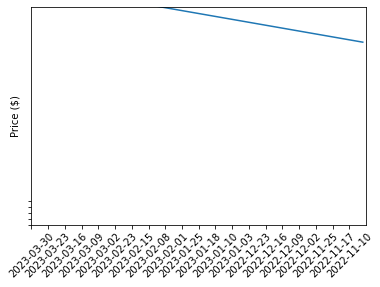

In [11]:
# Plot the adjusted closing prices of the stock
plt.plot(stock_data_df['5. adjusted close'])

# Scale the x-axis to show the full range of dates in ascending order
plt.xlim(0, len(stock_data_df))

# Set the x-tick locations to correspond to just the dates you entered.
plt.xticks(range(0, len(stock_data_df), 5), stock_data_df.index[::5], rotation=45)

# Scale the y-axis to show the full range of prices
plt.ylim(min(stock_data_df['5. adjusted close']), max(stock_data_df['5. adjusted close']))

# Set the y-tick locations to correspond to just the prices you entered.
plt.yticks(
    np.arange(float(min(stock_data_df['5. adjusted close'])), float(max(stock_data_df['5. adjusted close'])), 10.0))

# Set the y-axis label
plt.ylabel("Price ($)")

plt.show()

In [6]:
# Call the alpha vantage api to get the news data

# Set the ticker
ticker = "SCHW"

# Call the news api
news = api_calls.call_alpha_vantage_news(ticker)

# Convert time to datetime
for i in range(len(news['feed'])):
    news['feed'][i]['time_published'] = dt.datetime.strptime(news['feed'][i]['time_published'], "%Y%m%dT%H%M%S")

# Create a Pandas DataFrame
stock_news = pd.DataFrame(news['feed'])

# Display sample data
stock_news

,title,url,time_published,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
0,Pitney Bowes ( NYSE:PBI ) Stock Rating Lower...,https://www.defenseworld.net/2023/04/01/pitney...,2023-04-01 05:16:42,[Defense World Staff],Pitney Bowes ( NYSE:PBI - Get Rating ) was dow...,https://www.marketbeat.com/logos/pitney-bowes-...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Financial Markets', 'relevance_sco...",0.291819,Somewhat-Bullish,"[{'ticker': 'BLK', 'relevance_score': '0.14646..."
1,The Charles Schwab Corporation ( SCHW ) Stoc...,https://www.zacks.com/stock/news/2073378/the-c...,2023-03-31 22:00:18,[Zacks Investment Research],The Charles Schwab Corporation (SCHW) closed t...,https://staticx-tuner.zacks.com/images/default...,Zacks Commentary,n/a,www.zacks.com,"[{'topic': 'Earnings', 'relevance_score': '0.9...",0.191206,Somewhat-Bullish,"[{'ticker': 'SCHW', 'relevance_score': '0.6957..."
2,TD Announces Dividend Rates on Non-Cumulative ...,https://www.newswire.ca/news-releases/td-annou...,2023-03-31 21:20:00,[TD Bank Group],TD Announces Dividend Rates on Non-Cumulative ...,,Canada Newswire,n/a,www.newswire.ca,"[{'topic': 'Technology', 'relevance_score': '0...",0.377385,Bullish,"[{'ticker': 'TD', 'relevance_score': '0.967314..."
3,QuoteMedia Announces 16% Revenue Growth for 2022,https://www.globenewswire.com/news-release/202...,2023-03-31 19:10:00,"[Inc., QuoteMedia]","PHOENIX, March 31, 2023 ( GLOBE NEWSWIRE ) -- ...",https://ml.globenewswire.com/Resource/Download...,GlobeNewswire,n/a,www.globenewswire.com,"[{'topic': 'Financial Markets', 'relevance_sco...",0.387196,Bullish,"[{'ticker': 'BOM', 'relevance_score': '0.03566..."
4,"Investors 'are pretty afraid right now,' finan...",https://www.cnbc.com/2023/03/31/financial-psyc...,2023-03-31 17:34:49,[Annie Nova],We're in a period of high uncertainty and many...,https://image.cnbcfm.com/api/v1/image/10721798...,CNBC,Top News,www.cnbc.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.024427,Neutral,"[{'ticker': 'SCHW', 'relevance_score': '0.0875..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,H World Group ( NASDAQ:HTHT ) Now Covered by...,https://www.defenseworld.net/2023/03/17/h-worl...,2023-03-17 05:24:45,[Defense World Staff],Analysts at StockNews.com started coverage on ...,https://www.marketbeat.com/logos/h-world-group...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.287845,Somewhat-Bullish,"[{'ticker': 'DKNG', 'relevance_score': '0.0644..."
196,Aethlon Medical ( NASDAQ:AEMD ) Research Cov...,https://www.defenseworld.net/2023/03/17/aethlo...,2023-03-17 05:24:44,[Defense World Staff],Aethlon Medical ( NASDAQ:AEMD ) Research Cover...,https://www.marketbeat.com/logos/aethlon-medic...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Life Sciences', 'relevance_score':...",0.181982,Somewhat-Bullish,"[{'ticker': 'DKNG', 'relevance_score': '0.0925..."
197,Frontline ( NYSE:FRO ) Now Covered by Analys...,https://www.defenseworld.net/2023/03/17/frontl...,2023-03-17 05:24:44,[Defense World Staff],Research analysts at StockNews.com assumed cov...,https://www.americanbankingnews.com/wp-content...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.215066,Somewhat-Bullish,"[{'ticker': 'DKNG', 'relevance_score': '0.0810..."
198,Lindblad Expeditions ( NASDAQ:LIND ) Researc...,https://www.defenseworld.net/2023/03/17/lindbl...,2023-03-17 05:24:44,[Defense World Staff],Lindblad Expeditions ( NASDAQ:LIND ) Research ...,https://www.marketbeat.com/logos/lindblad-expe...,Stocknews.com,n/a,www.defenseworld.net,"[{'topic': 'Retail & Wholesale', 'relevance_sc...",0.244567,Somewhat-Bullish,"[{'ticker': 'BLK', 'relevance_score': '0.15851..."


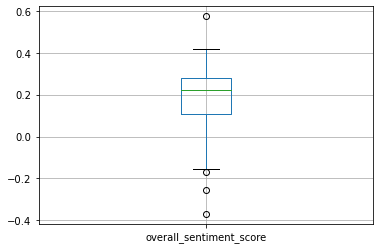

In [23]:
# Create a boxplot of the sentiment analysis of the news
stock_news.boxplot(column=['overall_sentiment_score'])
plt.show()